In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA

import utils

### Load data (MNIST)

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Conversion to float
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
# Normalization
x_train = x_train/255.0
x_test = x_test/255.0

X_train = x_train.reshape(len(x_train),-1)
X_test = x_test.reshape(len(x_test),-1)

In [3]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 784)
(60000,)
(10000,)


### Cluster input space

In [4]:
curr_digit = 0
eps = 3e-2

In [5]:
# Get labels for one-vs-all classification on curr_digit
one_v_all_trainloader, one_v_all_train_labels = utils.one_vs_all_dataloader(X_train, y_train, digit=curr_digit)

# Find RBF classification boundary in input space for curr_digit
input_cluster = SVC(kernel='rbf', C=1e-2, random_state=42, max_iter = 1e5).fit(X_train, one_v_all_train_labels)

In [6]:
# Test classification boundary found above
_, one_v_all_test_labels = utils.one_vs_all_dataloader(X_test, y_test, digit=curr_digit)

input_cluster.score(X_test, one_v_all_test_labels)

0.9896

### Train Model

Epoch 0 - Training loss: 0.3396594660289125
Epoch 1 - Training loss: 0.14460983498991012
Epoch 2 - Training loss: 0.0982893980346493
Epoch 3 - Training loss: 0.07253741189988373
Epoch 4 - Training loss: 0.05748607859803316
Epoch 5 - Training loss: 0.044049373519709153
Epoch 6 - Training loss: 0.03671703477594147
Epoch 7 - Training loss: 0.030738560278946635
Epoch 8 - Training loss: 0.024785172507000058
Epoch 9 - Training loss: 0.021644791235900553
Epoch 10 - Training loss: 0.016564490723486397
Epoch 11 - Training loss: 0.01594451567868044
Epoch 12 - Training loss: 0.014224630841386327
Epoch 13 - Training loss: 0.013331107361368798
Epoch 14 - Training loss: 0.01060611543172916

Training Time (in minutes) = 0.37441667715708415
Predicted Digit = 3
Number Of Images Tested = 10000

Model Accuracy = 0.9755


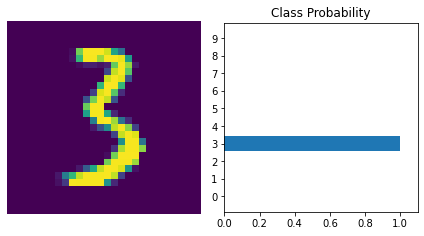

In [7]:
# Now let's start training the network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))

model = utils.train_model(model, X_train, X_test, y_train, y_test, epochs=15)

### Get model outputs

In [8]:
one_v_all_trainloader, _ = utils.one_vs_all_dataloader(X_train, y_train, digit=curr_digit)

outputs = utils.get_network_outputs(model, one_v_all_trainloader)

### Cluster output space

In [118]:
# Percentage of samples flagged as suspicious 
# C=5e-2: adv: ~13.3%, clean: ~8%
# C=5e-3: adv: ~20.8%, clean: ~7.6%
# C=1.25e-3: adv: 32.9%, clean: 7.4%
# C=1e-3: adv: ~35.8%, clean: ~8%
# C=7.5e-4: adv: ~39.7%, clean: ~11%
# C=5e-4: adv: ~56.6%, clean: ~21.8%
output_cluster = SVC(kernel='rbf', C=7.5e-4, random_state=42, max_iter = 1e5).fit(outputs, one_v_all_train_labels)

### Generate adversarial samples

In [119]:
one_v_all_testloader, _ = utils.one_vs_all_dataloader(X_test, y_test, digit=curr_digit)

adv_test_data = utils.add_adversarial_noise(model, one_v_all_testloader, eps=eps)

In [120]:
# Assess performance of input cluster classifier on adversarial data
input_cluster.score(adv_test_data, one_v_all_test_labels)

0.9859

In [121]:
# Assess performance of model on adversarial data
utils.eval_model(model, adv_test_data, y_test)

Number Of Samples Tested = 10000

Model Accuracy = 0.4869


In [122]:
# Get model outputs on adversarial data
one_v_all_advloader, one_v_all_labels = utils.one_vs_all_dataloader(adv_test_data, y_test, digit=curr_digit)

adv_outputs = utils.get_network_outputs(model, one_v_all_advloader)

In [123]:
# Assess performance of output cluster classifier on model output of adversarial data
output_cluster.score(adv_outputs, one_v_all_test_labels)

0.947

In [124]:
# Get input and output cluster predictions - if these disagree, we will consider the sample suspicious 
input_cluster_preds = input_cluster.predict(adv_test_data)
output_cluster_preds = output_cluster.predict(adv_outputs)

In [125]:
current_digit_idx = np.where(one_v_all_test_labels == 1)

In [126]:
# Proportion of adversarial data flagged as suspicious (in cluster in input but out of cluster in output)
(input_cluster_preds[current_digit_idx] != output_cluster_preds[current_digit_idx]).sum().item() / len(input_cluster_preds[current_digit_idx])

0.39693877551020407

In [127]:
# Proportion of clean data flagged as suspicious (in cluster in input but out of cluster in output)
clean_test_outputs = utils.get_network_outputs(model, one_v_all_testloader)

clean_in_cluster_preds = input_cluster.predict(X_test)
clean_out_cluster_preds = output_cluster.predict(clean_test_outputs)

(clean_in_cluster_preds[current_digit_idx] != clean_out_cluster_preds[current_digit_idx]).sum().item() / len(clean_in_cluster_preds[current_digit_idx])

0.11020408163265306